In [15]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import gwpopulation
from gwpopulation.models.redshift import MadauDickinsonRedshift
import bilby
import seaborn as sns
import pylab as plt
import os
import h5py
from sympy import symbols
import GWForge
import pycbc
import numpy as np
from scipy.signal import argrelextrema
import pandas as pd

# A-sharp

In [16]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#mass_band = 'above_80'
#mass_band = '40-80'
#mass_band = 'below_40'
#run_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 'Asharp',
#                       'mass_bands', mass_band, 'run05_gwfish_MDhigh_mf_from_opt_SNR_injections_XPHM',)
run_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 'Asharp', 
                       'run14_gwfish_MDhigh_mf_from_opt_SNR_injections_XPHM')

In [17]:
gwpop_result = bilby.result.read_in_result(filename=os.path.join(run_dir,
                                                                 'Asharp_result.hdf5'))
posterior_mf = gwpop_result.posterior

In [18]:
posterior_mf

,gamma,kappa,log_likelihood,log_prior,z_peak
0,2.146871,4.868760,44243.747229,-5.857933,1.935251
1,2.014693,3.660427,44245.496722,-5.857933,1.728438
2,1.421486,7.322112,44245.635042,-5.857933,2.695791
3,2.186020,5.069157,44245.662660,-5.857933,1.691851
4,2.245105,3.558672,44245.860641,-5.857933,1.354169
...,...,...,...,...,...
3165,1.690807,5.057029,44254.244841,-5.857933,2.175836
3166,1.694071,5.021642,44254.245109,-5.857933,2.166594
3167,1.692982,5.016619,44254.247783,-5.857933,2.168323
3168,1.647487,5.070412,44254.250214,-5.857933,2.217944


In [19]:
if 'MDlow' in run_dir:
    inj_pop = '5_pop_PLP_spin_prec_fref_10_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td.h5'
elif 'MDhigh' in run_dir:
    inj_pop = '4_pop_PLP_spin_prec_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22_365_days_corrected_td.h5'
else:
    inj_pop = '2_pop_PLP_spin_prec_fref_10_z_MD_zmax_10_lmrd_22_365_days_corrected_td.h5'
with h5py.File(os.path.join(project_dir, 
                            'input_population', 
                            'BBH', 
                            inj_pop), 'r') as f:
    injected_redshift = f['redshift'][:]
print(inj_pop)

4_pop_PLP_spin_prec_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22_365_days_corrected_td.h5


## Plot injected data

Text(0.5, 0, '$z$')

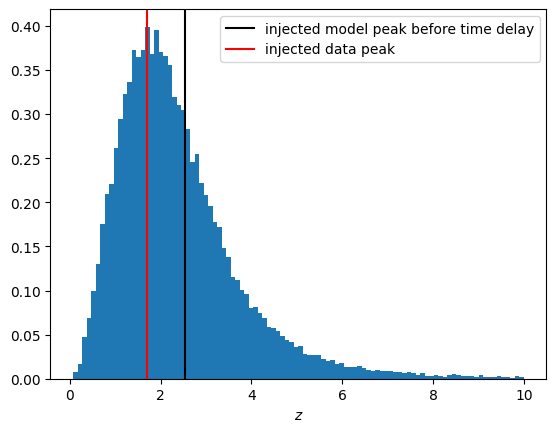

In [20]:
if 'MDhigh' in run_dir:
    inj_peak = 2.53
elif 'MDlow' in run_dir:
    inj_peak = 1.54
else:
    inj_peak = 1.9
plt.hist(injected_redshift, bins=100, density=True);
plt.axvline(inj_peak, c='k', label='injected model peak before time delay')
hData = np.histogram(injected_redshift, bins=100)
inj_z_peak_edge_idx = np.argmax(hData[0])
inj_z_peak = (hData[1][inj_z_peak_edge_idx] + hData[1][inj_z_peak_edge_idx + 1])/2
plt.axvline(inj_z_peak, c='r', label='injected data peak')
plt.legend()
plt.xlabel('$z$')

## Rebuild MDR model

In [21]:
MDR_model = MadauDickinsonRedshift(z_max=10)

In [22]:
if 'MDhigh' in run_dir:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 2.53}, 
                             'after_time_delay':{'gamma':1.7982, 'kappa':5.3226, 'z_peak':2.4199}}
elif 'MDlow' in run_dir:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.54}, 
                             'after_time_delay':{'gamma':1.8111, 'kappa':5.2753, 'z_peak':1.4917}}
else:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.9}, 
                             'after_time_delay':{'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}}

In [23]:
injected_hyper_params

{'before_time_delay': {'gamma': 2.7, 'kappa': 5.6, 'z_peak': 2.53},
 'after_time_delay': {'gamma': 1.7982, 'kappa': 5.3226, 'z_peak': 2.4199}}

## MF SNR injections

### Plot model at injection params vs median params

In [24]:
median_hyper_params_mf = {'gamma':np.median(posterior_mf['gamma']), 
                       'kappa':np.median(posterior_mf['kappa']), 
                       'z_peak':np.median(posterior_mf['z_peak'])}

In [25]:
sort_idx = np.argsort(injected_redshift)
inj_prob_arr = MDR_model.probability(dataset={'redshift':injected_redshift}, **injected_hyper_params['before_time_delay'])
z_grid = np.arange(0, 10, 0.01)
posterior_median_prob_arr_mf = MDR_model.probability(dataset={'redshift':z_grid}, **median_hyper_params_mf)

### Plot posterior bands

In [26]:
n_samples = 500
sample_idxs = np.random.choice(np.arange(len(posterior_mf['z_peak'])), n_samples, replace=False)
sample_params = {param:posterior_mf[param][sample_idxs] for param in ['gamma', 'kappa', 'z_peak']}
sample_params_records = pd.DataFrame(sample_params).to_dict(orient='records')

In [27]:
z_grid = np.arange(0, 10, 0.01)
posterior_prob_arr_list = []
for rec in sample_params_records:
    posterior_prob_arr_list.append(MDR_model.probability(dataset={'redshift':z_grid}, **rec))

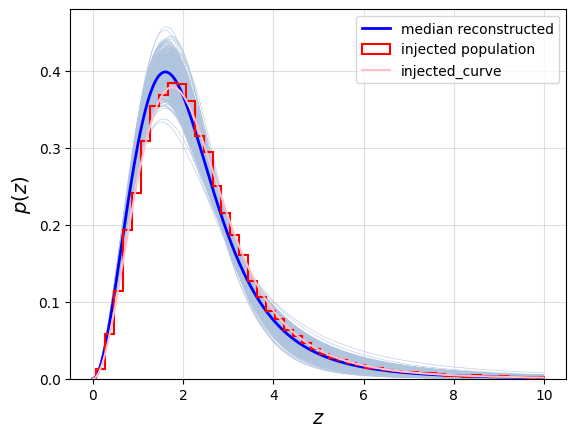

In [28]:
for i in posterior_prob_arr_list:
    plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5)
plt.plot(z_grid, posterior_median_prob_arr_mf, label='median reconstructed', c='b', lw=2)
plt.hist(injected_redshift, bins=50, density=True, color='r', histtype=u'step', lw=1.5, label='injected population');
plt.plot(z_grid, MDR_model.probability(dataset={'redshift':z_grid}, 
                                       **injected_hyper_params['after_time_delay']), 
         label='injected_curve', c='pink', lw=1.5)
#plt.axvline(1.9, c='k', label='$z_{peak}^{inj}$ before time delay')
plt.legend(loc=1)
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$p(z)$', fontsize=14)
plt.grid(alpha=0.4)
plt.savefig(os.path.join(run_dir, 'reconstructed_z.png'), dpi=300)

### Plot prior bands

In [ ]:
n_samples = 500
prior_samples = gwpop_result.priors.sample(n_samples)
prior_sample_records = pd.DataFrame(prior_samples).to_dict(orient='records')

: 

In [ ]:
prior_prob_arr_list = []
for rec in prior_sample_records:
    prior_prob_arr_list.append(MDR_model.probability(dataset={'redshift':z_grid}, **rec))

: 

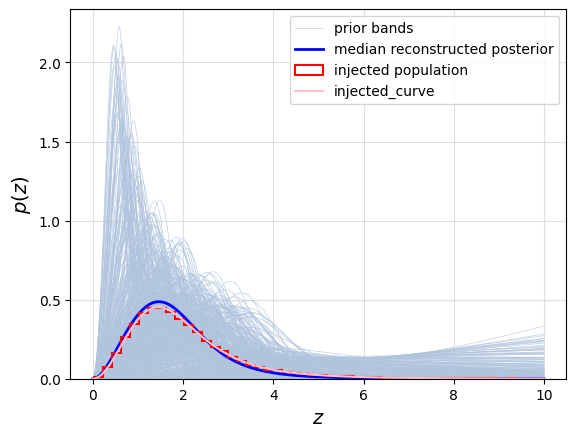

: 

In [ ]:
for j, i in enumerate(prior_prob_arr_list):
    if j == 0:
        plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5, label='prior bands')
    else:
        plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5)
plt.plot(z_grid, posterior_median_prob_arr_mf, label='median reconstructed posterior', c='b', lw=2)
plt.hist(injected_redshift, bins=50, density=True, color='r', histtype=u'step', lw=1.5, label='injected population');
plt.plot(z_grid, MDR_model.probability(dataset={'redshift':z_grid}, 
                                       **injected_hyper_params['after_time_delay']), 
         label='injected_curve', c='pink', lw=1.5)
#plt.axvline(1.9, c='k', label='$z_{peak}^{inj}$ before time delay')
plt.legend(loc=1)
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$p(z)$', fontsize=14)
plt.grid(alpha=0.4)

: 

# CE4020ET123

In [2]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#mass_band = 'below_40'
#mass_band = '40-80'
#mass_band = 'above_80'
if 'mass_band' in locals():
    print('Running for mass_band', mass_band)
    run_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                           'CE4020ET123', 'mass_bands', mass_band, 'run07_gwfish_MDlow_mf_from_opt_SNR_injections_XPHM')
else:
    run_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                           'CE4020ET123', 'run21_gwfish_MDlow_mf_from_opt_SNR_injections_XPHM')
print(run_dir)

/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/gwpop_analysis_results/CE4020ET123/run21_gwfish_MDlow_mf_from_opt_SNR_injections_XPHM


In [3]:
gwpop_result_mf_injs = bilby.result.read_in_result(filename=os.path.join(run_dir, 
                                                                         'CE4020ET123_result.hdf5'))
posterior_mf = gwpop_result_mf_injs.posterior

In [4]:
posterior_mf

,gamma,kappa,log_likelihood,log_prior,z_peak
0,1.912426,4.876551,40816.229225,-5.857933,1.262613
1,2.646966,5.607414,40818.165642,-5.857933,1.199541
2,2.328395,5.469886,40818.946963,-5.857933,1.328933
3,1.405670,5.459051,40819.698368,-5.857933,1.686977
4,1.032390,5.020876,40820.237850,-5.857933,1.826386
...,...,...,...,...,...
3183,1.815727,5.293650,40827.850721,-5.857933,1.455985
3184,1.843587,5.293012,40827.854572,-5.857933,1.442296
3185,1.819246,5.292476,40827.854634,-5.857933,1.453810
3186,1.870815,5.305272,40827.855207,-5.857933,1.427768


In [5]:
if 'MDlow' in run_dir:
    pop_str = '5_pop_set2_PLP_spin_prec_fref_5_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td.h5'
elif 'MDhigh' in run_dir:
    pop_str = '4_pop_PLP_spin_prec_fref_5_z_MDhigh_zp_2.53_zmax_10_lmrd_22_365_days_corrected_td.h5'
else:
    pop_str = '2_pop_PLP_spin_prec_z_MD_zmax_10_lmrd_22_365_days_corrected_td.h5'
with h5py.File(os.path.join(project_dir, 
                            'input_population', 
                            'BBH', 
                            pop_str), 'r') as f:
    injected_redshift = f['redshift'][:]

## Plot injected data

Text(0.5, 0, '$z$')

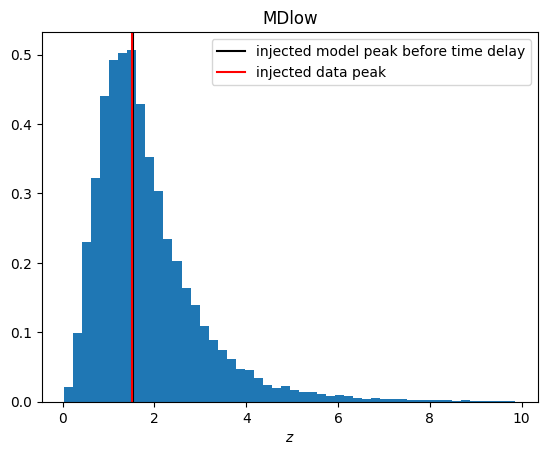

In [6]:
if 'MDhigh' in run_dir:
    inj_peak = 2.53
elif 'MDlow' in run_dir:
    inj_peak = 1.54
else:
    inj_peak = 1.9
plt.hist(injected_redshift, bins=50, density=True);
plt.axvline(inj_peak, c='k', label='injected model peak before time delay')
hData = np.histogram(injected_redshift, bins=50)
inj_z_peak_edge_idx = np.argmax(hData[0])
inj_z_peak = (hData[1][inj_z_peak_edge_idx] + hData[1][inj_z_peak_edge_idx + 1])/2
plt.axvline(inj_z_peak, c='r', label='injected data peak')
plt.legend()
plt.title(pop_str.split('_z_')[-1].split('_')[0])
plt.xlabel('$z$')

## Rebuild MDR model

In [7]:
MDR_model = MadauDickinsonRedshift(z_max=10)

In [8]:
if 'MDhigh' in run_dir:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 2.53}, 
                             'after_time_delay':{'gamma':1.7982, 'kappa':5.3226, 'z_peak':2.4199}}
elif 'MDlow' in run_dir:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.54}, 
                             'after_time_delay':{'gamma':1.8111, 'kappa':5.2753, 'z_peak':1.4917}}
else:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.9}, 
                             'after_time_delay':{'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}}

## MF SNR injections

### Plot model at injection params vs median params

In [9]:
median_hyper_params_mf = {'gamma':np.median(posterior_mf['gamma']), 
                       'kappa':np.median(posterior_mf['kappa']), 
                       'z_peak':np.median(posterior_mf['z_peak'])}

In [10]:
sort_idx = np.argsort(injected_redshift)
inj_prob_arr = MDR_model.probability(dataset={'redshift':injected_redshift}, **injected_hyper_params['before_time_delay'])
z_grid = np.arange(0, 10, 0.01)
posterior_median_prob_arr_mf = MDR_model.probability(dataset={'redshift':z_grid}, **median_hyper_params_mf)

### Plot posterior bands

In [11]:
n_samples = 500
sample_idxs = np.random.choice(np.arange(len(posterior_mf['z_peak'])), n_samples, replace=False)
sample_params = {param:posterior_mf[param][sample_idxs] for param in ['gamma', 'kappa', 'z_peak']}
sample_params_records = pd.DataFrame(sample_params).to_dict(orient='records')

In [12]:
z_grid = np.arange(0, 10, 0.01)
posterior_prob_arr_list = []
for rec in sample_params_records:
    posterior_prob_arr_list.append(MDR_model.probability(dataset={'redshift':z_grid}, **rec))

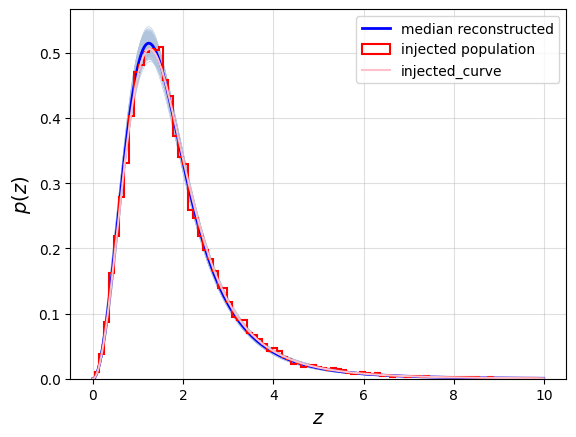

In [13]:
for i in posterior_prob_arr_list:
    plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5)
plt.plot(z_grid, posterior_median_prob_arr_mf, label='median reconstructed', c='b', lw=2)
plt.hist(injected_redshift, bins=90, density=True, color='r', histtype=u'step', lw=1.5, label='injected population');
plt.plot(z_grid, MDR_model.probability(dataset={'redshift':z_grid}, 
                                       **injected_hyper_params['after_time_delay']), 
         label='injected_curve', c='pink', lw=1.5)
#plt.axvline(1.9, c='k', label='$z_{peak}^{inj}$ before time delay')
plt.legend()
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$p(z)$', fontsize=14)
plt.grid(alpha=0.4)
plt.savefig(os.path.join(run_dir, 'reconstructed_z.png'), dpi=300)